In [1]:
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

┌ Info: Precompiling Nevanlinna [0b21cfa8-e591-48a4-a07b-a9d20be7c264]
└ @ Base loading.jl:1423


In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

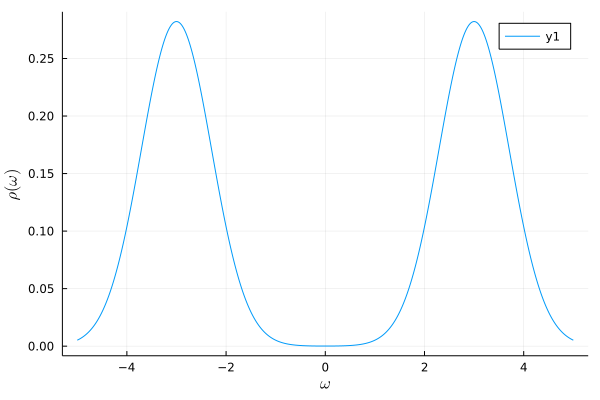

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#on-centered gaussian 23s
#rho(omega) = gaussian(omega, 0.0, 0.15)  

#on-centered lorentzian 2340s
#rho(omega) = lorentzian(omega, 0.0, 0.15)  

#two peak model 4403s
#rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)

#rho(omega) = 0.8*lorentzian(omega, -1.0, 1.6) + 0.2*lorentzian(omega, 3, 1)

#three peak model 1255s
#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

# Hubbard gap 2619s
rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
setprecision(512)
;

In [5]:
beta = 100
wmax = 100
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;

In [6]:
#off-centered delta function
#rhol = (IR_basis_set.basis_f.v(0.2))
#gl = - IR_basis_set.basis_f.s .* rhol
;

In [7]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

52

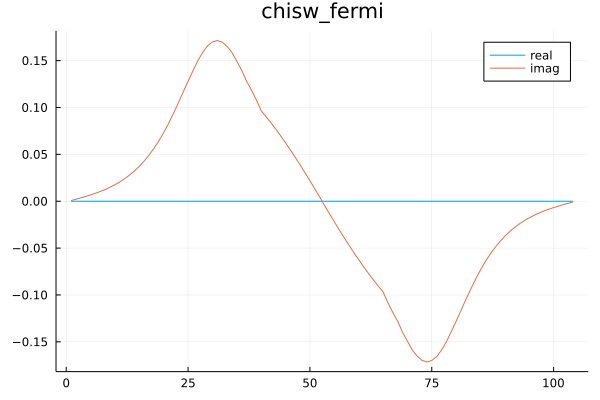

In [8]:
plot(title="chisw_fermi")
plot!(real.(gw[:]), label="real")
plot!(imag.(gw[:]), label="imag")

In [9]:
sum = -dot(IR_basis_set.basis_f.u(beta), gl) - dot(IR_basis_set.basis_f.u(0), gl)

1.0000000000000013

In [10]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [11]:
for i in 1:hnw
    test_smpl[i]= SparseIR.valueim(IR_basis_set.smpl_wn_f.sampling_points[hnw+i], SparseIR.β(IR_basis_set))
    test_gw[i]  = gw[hnw+i]
end

In [18]:
N_real    =  10000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 38
println("N_imp $(N_imag)")
;

N_imag is setted as 31
N_imp 31


In [21]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, sum, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.444893e+03     1.117940e+03
 * time: 0.0001919269561767578
     1     1.092402e+03     7.841165e+02
 * time: 15.758954048156738
     2     5.933025e+02     3.496069e+02
 * time: 31.788474082946777
     3     5.087430e+02     2.386954e+02
 * time: 34.232933044433594
     4     6.215028e+01     3.915047e+01
 * time: 39.147412061691284
     5     2.240885e+01     9.462459e+01
 * time: 55.18552589416504
     6     1.378720e+01     3.850231e+01
 * time: 67.60596299171448
     7     1.295125e+01     3.392047e+01
 * time: 71.3123300075531
     8     6.669779e+00     6.083520e+00
 * time: 75.11652088165283
     9     6.269163e+00     2.049414e+00
 * time: 78.7803270816803
    10     6.153103e+00     2.128608e+00
 * time: 82.45876693725586
    11     6.108920e+00     2.267025e+00
 * time: 84.93550610542297
    12     6.060455e+00     2.595988e+00
 * time: 87.41315388679504
    13     5.985371e+00   

    14     1.071565e+03     1.437262e+02
 * time: 161.27658796310425
    15     9.412320e+02     1.341766e+02
 * time: 165.67944312095642
    16     6.791185e+02     7.443514e+01
 * time: 175.87713813781738
    17     6.473560e+02     6.709535e+01
 * time: 196.55808806419373
    18     6.350369e+02     6.739459e+01
 * time: 214.08163213729858
    19     6.234026e+02     6.518223e+01
 * time: 237.53908705711365
    20     6.217589e+02     6.451170e+01
 * time: 247.9438979625702
    21     6.210533e+02     6.440220e+01
 * time: 253.77569603919983
    22     5.922980e+02     4.734571e+01
 * time: 256.64822602272034
    23     5.000935e+02     6.901929e+01
 * time: 264.0562629699707
    24     1.563895e+02     2.393680e+01
 * time: 271.37254309654236
    25     7.058547e+01     2.385760e+01
 * time: 284.5993161201477
    26     3.996220e+01     4.320661e+01
 * time: 297.7981159687042
    27     3.871246e+01     5.948535e+01
 * time: 302.1909689903259
    28     2.639743e+01     1.138459e+0

   135     3.834058e+00     1.930262e-01
 * time: 780.3956091403961
   136     3.831227e+00     1.384109e-01
 * time: 783.2746739387512
   137     3.829012e+00     1.351555e-01
 * time: 786.2195720672607
   138     3.826801e+00     1.492799e-01
 * time: 790.6665179729462
   139     3.825014e+00     1.185858e-01
 * time: 793.4871890544891
   140     3.821003e+00     1.464083e-01
 * time: 797.9007520675659
   141     3.819323e+00     1.520888e-01
 * time: 800.7954061031342
   142     3.818066e+00     1.588547e-01
 * time: 803.6999530792236
   143     3.816953e+00     1.298685e-01
 * time: 806.7060551643372
   144     3.815471e+00     1.791074e-01
 * time: 809.5488801002502
   145     3.814809e+00     1.513343e-01
 * time: 812.5535769462585
   146     3.812950e+00     2.163039e-01
 * time: 816.8448629379272
   147     3.811517e+00     1.955920e-01
 * time: 819.7408621311188
   148     3.802582e+00     3.836641e-01
 * time: 824.1379401683807
   149     3.790403e+00     4.494885e-01
 * time

   255     3.617603e+00     1.108968e-05
 * time: 1195.1173510551453
   256     3.617603e+00     6.616059e-06
 * time: 1198.0662460327148
   257     3.617603e+00     6.360766e-06
 * time: 1200.9640741348267
   258     3.617603e+00     3.897426e-06
 * time: 1203.9042000770569
   259     3.617603e+00     3.798622e-06
 * time: 1206.8096051216125
   260     3.617603e+00     2.812681e-06
 * time: 1209.720587015152
   261     3.617603e+00     2.754505e-06
 * time: 1212.6268739700317
   262     3.617603e+00     2.003475e-06
 * time: 1215.5217571258545
   263     3.617603e+00     1.932738e-06
 * time: 1218.509948015213
   264     3.617603e+00     1.306699e-06
 * time: 1221.339956998825
   265     3.617603e+00     1.220480e-06
 * time: 1224.347941160202
   266     3.617603e+00     7.732027e-07
 * time: 1227.1665320396423
   267     3.617603e+00     6.943712e-07
 * time: 1230.1690740585327
   268     3.617603e+00     4.169939e-07
 * time: 1232.993756055832
   269     3.617603e+00     3.603938e-0

     7     7.657200e+00     5.971627e+00
 * time: 92.53941583633423
     8     7.028497e+00     4.256520e+00
 * time: 97.67067790031433
     9     6.778353e+00     4.017747e+00
 * time: 106.05347800254822
    10     6.683844e+00     3.565939e+00
 * time: 111.09799480438232
    11     6.427091e+00     3.474980e+00
 * time: 117.7739999294281
    12     6.276387e+00     3.625575e+00
 * time: 121.19693303108215
    13     6.234289e+00     2.786606e+00
 * time: 126.35121297836304
    14     6.217687e+00     2.593347e+00
 * time: 133.0129098892212
    15     6.147683e+00     2.983002e+00
 * time: 138.05120992660522
    16     6.013535e+00     2.275287e+00
 * time: 146.3252079486847
    17     5.665804e+00     3.135958e+00
 * time: 149.77339100837708
    18     5.644829e+00     2.912978e+00
 * time: 161.47245693206787
    19     5.617399e+00     2.735951e+00
 * time: 168.09454083442688
    20     5.433408e+00     2.401361e+00
 * time: 173.12807703018188
    21     5.105323e+00     1.705418e+0

   128     4.150638e+00     8.010802e-02
 * time: 642.2308938503265
   129     4.150566e+00     7.335778e-02
 * time: 645.7129759788513
   130     4.150312e+00     6.904173e-02
 * time: 649.0009729862213
   131     4.149994e+00     7.716034e-02
 * time: 652.4791429042816
   132     4.149702e+00     6.522758e-02
 * time: 659.3124189376831
   133     4.149467e+00     6.246768e-02
 * time: 662.6350569725037
   134     4.149278e+00     6.016922e-02
 * time: 667.8167428970337
   135     4.149131e+00     5.168970e-02
 * time: 671.2319648265839
   136     4.149102e+00     4.855456e-02
 * time: 674.6248090267181
   137     4.148986e+00     4.665097e-02
 * time: 678.0467178821564
   138     4.148450e+00     6.789680e-02
 * time: 683.1714890003204
   139     4.148306e+00     4.568604e-02
 * time: 689.9698588848114
   140     4.148209e+00     5.793464e-02
 * time: 693.4323320388794
   141     4.148096e+00     5.250251e-02
 * time: 698.5299689769745
   142     4.148001e+00     4.799843e-02
 * time

   249     4.024699e+00     5.311295e-02
 * time: 1214.6906428337097
   250     4.024019e+00     5.430549e-02
 * time: 1219.8371958732605
   251     4.023878e+00     5.127005e-02
 * time: 1223.0832648277283
   252     4.023626e+00     4.891210e-02
 * time: 1226.4137909412384
   253     4.023433e+00     4.235068e-02
 * time: 1229.7078359127045
   254     4.023224e+00     4.917735e-02
 * time: 1234.7780828475952
   255     4.023038e+00     5.469667e-02
 * time: 1238.0662569999695
   256     4.022791e+00     5.245866e-02
 * time: 1241.3244729042053
   257     4.022383e+00     5.498594e-02
 * time: 1246.3386750221252
   258     4.022264e+00     5.241039e-02
 * time: 1249.6251230239868
   259     4.022059e+00     6.033542e-02
 * time: 1253.0476639270782
   260     4.021929e+00     4.845764e-02
 * time: 1257.9306848049164
   261     4.021660e+00     4.180474e-02
 * time: 1264.5256810188293
   262     4.021415e+00     3.603218e-02
 * time: 1267.8272178173065
   263     4.021318e+00     3.4761

   369     4.020393e+00     1.934497e-05
 * time: 1665.5623559951782
   370     4.020393e+00     1.561979e-05
 * time: 1669.0336139202118
   371     4.020393e+00     1.445915e-05
 * time: 1672.5995588302612
   372     4.020393e+00     1.247835e-05
 * time: 1676.203869819641
   373     4.020393e+00     1.168418e-05
 * time: 1679.816113948822
   374     4.020393e+00     9.815310e-06
 * time: 1683.3223178386688
   375     4.020393e+00     9.463133e-06
 * time: 1686.8880820274353
   376     4.020393e+00     8.036215e-06
 * time: 1690.308058977127
   377     4.020393e+00     6.635794e-06
 * time: 1693.8696339130402
   378     4.020393e+00     6.609602e-06
 * time: 1697.3882749080658
   379     4.020393e+00     4.658455e-06
 * time: 1700.913146018982
   380     4.020393e+00     5.625101e-06
 * time: 1704.4232490062714
   381     4.020393e+00     3.455593e-06
 * time: 1707.9479398727417
   382     4.020393e+00     4.663888e-06
 * time: 1711.4305939674377
   383     4.020393e+00     2.614298e-

    53     2.743469e+01     1.444297e+01
 * time: 468.5836181640625
    54     2.510409e+01     2.602728e+01
 * time: 483.34486508369446
    55     2.303155e+01     1.888655e+01
 * time: 496.5751781463623
    56     2.293004e+01     1.259045e+01
 * time: 503.9350950717926
    57     2.259913e+01     1.779412e+01
 * time: 511.3037209510803
    58     2.258516e+01     1.044348e+01
 * time: 515.0914640426636
    59     2.102861e+01     4.087041e+01
 * time: 522.4446921348572
    60     2.020187e+01     1.752943e+01
 * time: 528.0089931488037
    61     1.927075e+01     2.532760e+01
 * time: 533.6005079746246
    62     1.630420e+01     2.015580e+01
 * time: 542.9735369682312
    63     1.616779e+01     4.008584e+01
 * time: 548.5593459606171
    64     1.533261e+01     3.470237e+01
 * time: 552.3906610012054
    65     1.460115e+01     4.069787e+01
 * time: 557.9957120418549
    66     1.350151e+01     1.016768e+01
 * time: 563.5793199539185
    67     1.189189e+01     1.321216e+01
 * tim

LoadError: InterruptException:

In [22]:
@time Nevanlinna.solve!(sol)

InterruptException: InterruptException:

In [23]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, sum, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

InterruptException: InterruptException:

In [24]:
plot(real.(raw_reals.freq), imag.(raw_reals.val)/pi)
#plot!(omegas, rho.(omegas))

InterruptException: InterruptException:

In [25]:
plot()
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

LoadError: UndefVarError: sol not defined

In [37]:
imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
#noopt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#opt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#noopt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
#opt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
noopt_raw_reals = Nevanlinna.RealDomainData(200, omega_max, eta, T=T)
opt_raw_reals = Nevanlinna.RealDomainData(200, omega_max, eta, T=T)
noopt_raw_reals.freq .= ((collect(1:200).-100)/1000000)*2*pi*im/beta
opt_raw_reals.freq .= ((collect(1:200).-100)/1000000)*2*pi*im/beta
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, noopt_raw_reals, phis)
ab_coeff  = zeros(ComplexF64, 2*sol.H) 
hardy_matrix = Nevanlinna.calc_hardy_matrix(noopt_raw_reals, sol.H)

Nevanlinna.evaluation!(noopt_raw_reals, abcd, sol.H, ab_coeff, hardy_matrix)
Nevanlinna.evaluation!(opt_raw_reals, abcd, sol.H, sol.ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.


LoadError: MethodError: no method matching RealDomainData(::Int64, ::Float64, ::Float64; T=BigFloat)
[0mClosest candidates are:
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m; T, small_omega, mesh) at ~/work/Nevanlinna/src/data.jl:55
[0m  RealDomainData(::Int64, ::Float64, ::Float64, [91m::Float64[39m, [91m::Array{Complex{T}, 1}[39m, [91m::Array{Complex{T}, 1}[39m) where T<:Real at ~/work/Nevanlinna/src/data.jl:47[91m got unsupported keyword argument "T"[39m

In [38]:
using FastGaussQuadrature
using OMEinsum
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_green_z(z::Vector{ComplexF64}, xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    newaxis = [CartesianIndex()]
    green_z = ein"q,q,wq->w"(
            quad_rule[2],
            rho.(quad_rule[1]),
            1 ./ (z[:, newaxis] .- quad_rule[1][newaxis, :])
        )
    return green_z
end
#exact_g = calc_green_z(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag])*im*pi/beta, -omega_max, omega_max, 1000)
exact_g = calc_green_z(((collect(1:200).-100)/1000000)*2*pi*im/beta, -omega_max, omega_max, 1000000)

;

LoadError: ArgumentError: Package FastGaussQuadrature not found in current path:
- Run `import Pkg; Pkg.add("FastGaussQuadrature")` to install the FastGaussQuadrature package.


In [39]:
using FastGaussQuadrature
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_sum_omega(xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    sum_omega = 0.0
    for i in 1:deg
        sum_omega += (quad_rule[2] .* rho.(quad_rule[1]))[i]
    end

    return sum_omega
end
sum_o = calc_sum_omega(-omega_max, omega_max, 1000)

LoadError: ArgumentError: Package FastGaussQuadrature not found in current path:
- Run `import Pkg; Pkg.add("FastGaussQuadrature")` to install the FastGaussQuadrature package.


In [40]:
exact_g[11]

LoadError: UndefVarError: exact_g not defined

In [41]:
plot()
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(exact_g)), xlim=[0,0.3],label="real_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-opt_raw_reals.val)), label="real_nopt_dense")
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(exact_g)), xlim=[0,0.01],label="imag_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
plot!(((collect(1:200).-100)/100000)*2*pi/beta, Float64.(imag.(-opt_raw_reals.val)), label="imag_nopt_dense")

LoadError: UndefVarError: exact_g not defined

In [42]:
plot()
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-noopt_raw_reals.val-exact_g)), xlim = [0,0.01], label="real_nonopt_dense", xlabel=latexstring("\\omega"), ylabel=latexstring("|\\Delta G(i\\omega_\\nu)|"), yaxis=:log)
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-opt_raw_reals.val-exact_g)), label="real_opt_dense")

LoadError: UndefVarError: noopt_raw_reals not defined

In [43]:
#plot()
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(exact_g)), label="real_exact", xlabel=latexstring("\\nu"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-opt_raw_reals.val)), label="real_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(real.(test_gw[1:N_imag])), label="real_sparse")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(exact_g)), label="imag_exact")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-opt_raw_reals.val)), label="imag_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(imag.(test_gw[1:N_imag])), label="imag_sparse")

In [25]:
#plot()
#plot(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-noopt_raw_reals.val.-exact_g)), yaxis=:log, label="abs_nonopt_dense", xlabel=latexstring("\\nu"), ylabel=latexstring("\\Delta |G(i\\omega_\\nu)|"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-opt_raw_reals.val-exact_g)), label="abs_opt_dense")

In [26]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [27]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#